# Library Imports

In [1]:
import cv2
import glob
from IPython.display import HTML
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
import numpy as np
import pandas as pd
import re
import seaborn as sns
% matplotlib inline

# Camera Calibration Method

In [2]:
def CalibrateCamera(cal_img_dir='./camera_cal', nx=9, ny=6, debug=True):
    """Compute camera matrix and distortion coeffecients using calibration images.
    
    Args:
      cal_img_dir: Directory containing calibration images of the form *.jpg.
      nx: Number of corners in the x-direction (columns).
      ny: Number of corners in the y-direction (row).
      degug: Boolean indicating whether to display calibration images.
    Returns:
      Camera matrix and camera distortion coeffecients.
    """
    # Image and object point collections
    img_points = []
    obj_points = []
    
    # Chessboard objpoints
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    for img_path in glob.glob('%s/*.jpg' % cal_img_dir):
        # Read in the image and covert to gray
        img = cv2.imread(img_path)
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect image corners
        ret, corners = cv2.findChessboardCorners(gray_img, (nx, ny), None)
        
        if ret == True:
            # Collect obj and img points.
            obj_points.append(objp)
            img_points.append(corners)
            
            # Draw detected corners on 
            if debug==True:
                cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.figure()
                plt.imshow(img)
                plt.grid(False)
                plt.show()
        else:
            if debug==True:
                print('Failed to detect corners in image: %s' % img_path)

    # Compute camera matrix and distortion coeffecients.
    _, mtx, dist, _, _ = cv2.calibrateCamera(obj_points, img_points, img.shape[:2], None, None)
    
    return mtx, dist

# Examples of Removing Distortion From Images

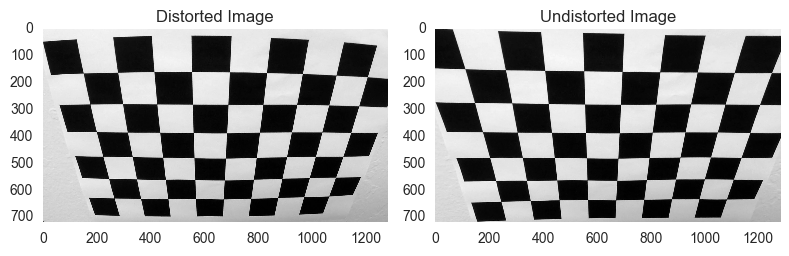

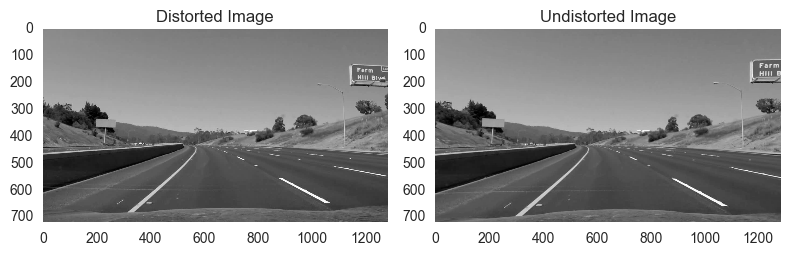

In [3]:
# Calibrate Camera
mtx, dist = CalibrateCamera(debug=False)

# Visualize image distortion correction for a calibration image.
img = cv2.imread('./camera_cal/calibration2.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,6))
ax1.imshow(gray_img, cmap='gray')
ax1.grid(False)
ax1.set_title('Distorted Image')
ax2.imshow(cv2.undistort(gray_img, mtx, dist, None, mtx), cmap='gray')
ax2.grid(False)
ax2.set_title('Undistorted Image')
plt.tight_layout()
plt.show()

# Visualize image distortion correction for a video frame.
img = cv2.imread('project_video_test_images/image054.jpg')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

fig2, (ax3, ax4) = plt.subplots(1,2,figsize=(8,6))
ax3.imshow(gray_img, cmap='gray')
ax3.grid(False)
ax3.set_title('Distorted Image')
ax4.imshow(cv2.undistort(gray_img, mtx, dist, None, mtx), cmap='gray')
ax4.grid(False)
ax4.set_title('Undistorted Image')
plt.tight_layout()
plt.show()

# Perspective Transform Method

In [4]:
def GetPerspectiveTransform(src_pts, dst_pts):
    """Compute perspective transformation and inverse transformation.
    Args:
      src_pts: Numpy 4X2 array corresponding to four x,y points pairs.
      dst_pts: Numpy 4X2 array correspoding to four x,y points pairs.
    Returns:
      Matrices corresponding perspective transformation and inverse transformation.
    """
    M = cv2.getPerspectiveTransform(src_pts, dst_pts)
    Minv = cv2.getPerspectiveTransform(dst_pts, pts)
    return M, Minv

# Examples Perspective Transformation from Camera View to Bird's Eye-View

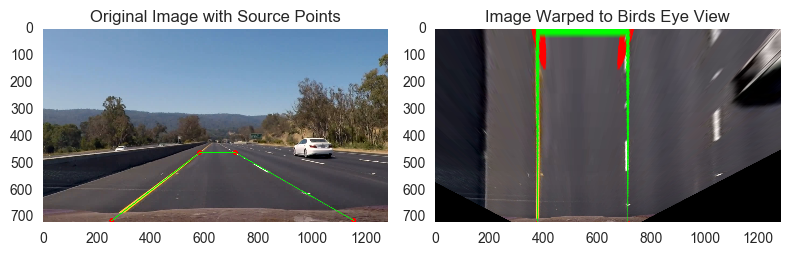

In [5]:
# Read image used to get perspective transform.
img = mpimg.imread('project_video_test_images/image404.jpg')

# Define source and destination coordinates used to derive perspective transform.
pts =np.array([[255, 714], 
               [581, 462], 
               [713, 462], 
               [1153, 714]]).astype(np.float32)

dst_pts = np.array([[379, img.shape[0]], 
                    [379, 0], 
                    [713, 0],
                    [713, img.shape[0]]]).astype(np.float32)


# Draw source points on original image
for i in range(0,pts.shape[0]):
    cv2.circle(img, (pts[i,0], pts[i,1]), 6, (255, 0, 0), 6)
for i in range(1,pts.shape[0]):
    cv2.line(img, (pts[i-1,0], pts[i-1,1]), (pts[i,0], pts[i,1]),  (0,255,0), 2)
    
# Get perspective transform
M, Minv = GetPerspectiveTransform(pts, dst_pts)
warped_img = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,6))
ax1.imshow(img)
ax1.grid(False)
ax1.set_title('Original Image with Source Points')
ax2.imshow(warped_img)
ax2.grid(False)
ax2.set_title('Image Warped to Birds Eye View')
plt.tight_layout()
plt.show()

# Region of Interest (ROI) Method

In [6]:
def extract_roi(img, roi_vertices):
    """Extracts region of interest from an image.
    
    Args:
      img: Image from which to extract region of interest.
      roi_vertices: Numpy array of x,y points specifying region of interest.
    Returns:
      New image containing only the pixels within the region of interest.
    """
    if len(img.shape) == 3:
        img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        img_gray = img
    mask = np.zeros_like(img_gray)
    cv2.fillPoly(mask, roi_vertices, 255)
    masked_img = cv2.bitwise_and(img_gray, mask)
    return masked_img

# Example Region of Interest Extraction

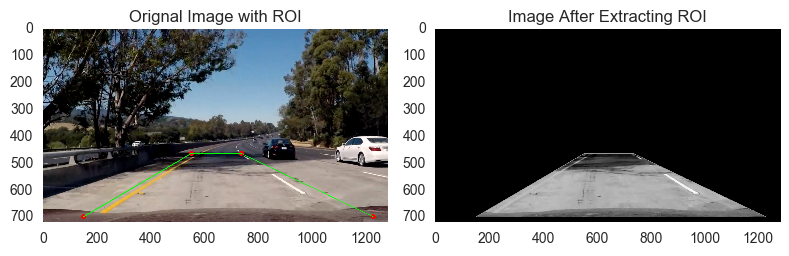

In [7]:
# Read image used to get perspective transform.
img = mpimg.imread('test_images/test5.jpg')

roi_vertices = np.array([[150, 700], 
                         [550, 465],
                         [735, 465],
                         [1225, 700]])

# Draw ROI on original image
for i in range(0,pts.shape[0]):
    cv2.circle(img, (roi_vertices[i,0], roi_vertices[i,1]), 6, (255, 0, 0), 6)
for i in range(1,pts.shape[0]):
    cv2.line(img, 
             (roi_vertices[i-1,0], roi_vertices[i-1,1]), 
             (roi_vertices[i,0], roi_vertices[i,1]),  
             (0,255,0), 2)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,6))
ax1.imshow(img)
ax1.grid(False)
ax1.set_title('Orignal Image with ROI')
ax2.imshow(extract_roi(img, [roi_vertices]), cmap='gray')
ax2.grid(False)
ax2.set_title('Image After Extracting ROI')
plt.tight_layout()
plt.show()

## Helper Methods For Lane Detection

In [8]:
YM_PER_PIX = 30/720 # meters per pixel in y dimension
XM_PER_PIX = 3.7/334 # meteres per pixel in x dimension

def threshold_color_img(img, channel=2, thresh=(0,255), colorspace=None):
    """Apply threshold to particular channel of an image in a user-specified colorspace.
    
    This method is called by apply_color_grad_thresholds(...)
    
    Args:
      img: Input RGB image to be thresholded.
      channel: Index of the channel to be thresholded.
      thresh: Tuple specifying low and high thresholds.
      colorspace: Colorspace conversion (e.g. cv2.RGB2HSV or cv2.RGB2HLS)
    Returns:
      Binary image where pixel intensity in specified channel and colorspace 
        are satisfied.
    """
    if colorspace is not None:
        img = cv2.cvtColor(img, colorspace)
    img_chan = img[:,:,channel]
    binary_img = np.zeros_like(img_chan)
    binary_img[(img_chan > thresh[0]) & (img_chan <= thresh[1])] = 1
    return binary_img

def threshold_gradient(img, ksize=3, thresh_grad=(0,255), thresh_orient=(0,np.pi/2)):
    """Apply threshold to image gradient magnitude and gradient orientation.
    
    This method is called by apply_color_grad_thresholds(...)
    
    Args:
      img: Input RGB image to be thresholded.
      ksize: Kernel size for image gradient computation.
      thresh_grad: Tuple specifying low and high thresholds for gradient magnitude.
      thresh_orient: Tuple specifying low and high thresholds for gradient orientation.
    Returns:
      Binary image where gradient magnitude and orientation are satisfied.
    """
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gradx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0)
    grady = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1)
    grad_mag = np.sqrt(gradx**2 + grady**2)
    grad_mag = np.uint8(255. * grad_mag/np.max(grad_mag))
    grad_orient = np.arctan2(np.absolute(grady), np.absolute(gradx))
    binary_image = np.zeros_like(img_gray)
    binary_image[((grad_mag > thresh_grad[0]) & (grad_mag < thresh_grad[1])) &
                 ((grad_orient > thresh_orient[0]) & (grad_orient < thresh_orient[1]))] = 1
    return binary_image

def apply_color_grad_thresholds(img):
    """Apply color and gradient thresholds to an image.
    
    Thresholds red-channel of input image in the interval 210-255
    Thresholds gradient magnitude between 85-255 and orientation between pi/4-3pi/4
    
    Args:
      img: Input RGB image to be thresholded.
    Returns:
      Binary image where color and gradient thresholds are statisfied.
    """
    # Threshold red-channel intensity.
    binary_red_img = threshold_color_img(
        img, channel=0, thresh=(210,255), colorspace=None)
    # Threshold gradient magnitude and orientation
    binary_grad_img = threshold_gradient(
        img, thresh_grad=(85, 255), thresh_orient=(np.pi/4, 3*np.pi/4))
    # Create color image representing threshold activations for visualization
    color_img = 255 * np.dstack((binary_red_img, binary_grad_img, 0*binary_grad_img))
    # Create binary image represetning threshold activations
    binary_img = np.zeros_like(binary_red_img)
    binary_img[(binary_red_img == 1) | (binary_grad_img == 1)] = 255
    return binary_img, color_img

def fill_lane_region(warped, left_fitx, right_fitx, yvals):
    """Fills the region between to fitted lane curves.
    
    Args:
      warped: Input image warped to bird's eye-view.
      left_fitx: X-coordinates for the fitted left-lane curve.
      right_fitx: X-coordinates for the fitted right-lane curve.
      yvals: Y-coordinates associated with left_fitx and right_fitx.
    Returns:
      RGB image with region between lane curves filled.
    """
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    return color_warp

# Class For Tracking Right and Left Lane Curves

In [12]:
# Define a class to receive the characteristics of each line detection
class Line():
    
    def __init__(self, num_fits=10, num_curve_samples=720, search_interval=(0,600), poly_degree=2):        
        # was the line detected in the last frame.
        self.detected = False 
        
        # number of curve fits to save for the purposes of smoothing.
        self.num_fits = num_fits
        # how many samples in each lane curve fit.
        self.num_curve_samples = num_curve_samples
        # numpy array storing lane curve fits for the last self.num_fits fits.
        self.recent_xfitted = np.ones((self.num_fits, self.num_curve_samples)) * np.nan
        # average x values of the fitted curves over the last self.num_fits iterations.
        self.bestx = None     
        
        # polynomial coefficients averaged over the last self.num_fits iterations.
        self.best_poly = None  
        # numpy array storing previous polynomial coefficients for the last self.num_fits fits.
        self.recent_poly_fitted = np.ones((num_fits, poly_degree+1)) * np.nan
        # maximum absolute difference between coffecients of polynomials across frames.
        self.coeff_diff_threshold = 0.5
        
        # x values for detected line pixels.
        self.allx = None  
        # y values for detected line pixels.
        self.ally = None
        
        # radius of curvature of the line.
        self.radius_of_curvature = None 

        # last frame number with a successful lane detection
        self.last_frame_detect = -1*np.inf
        
        # counter indicating the number of the curve being fit.
        self.fit_number = 0
        
        # x-range within which to search for lane in the 
        # abscence of a detection from the previous iteration
        self.search_interval = search_interval
        
    def extract_lane_pixels(self, img, win_start=500, win_height=300, win_width=30, 
                            win_shift=25, lane_pos=None):
        """Method for collecting all points associated with a lane from a binary image.
        
        See Advanced_Lane_Solution.pdf for description of methodology.
        
        Args:
          img: Binary img with potential lane pixels.
          win_start: Starting row of analysis window uses to collect lane pixels.
          win_height: Height of analysis window used to collect lane pixels.
          win_width: Width of analysis window used to collect lane pixels.
          win_shift: Numer of rows by which to slide analysis window.
          lane_pos: X-coordinates of lane from previous frame if detection is 
            available.
        Returns:
          Y,X-coordinates of all pixels associated with a lane in the input image.  
            Also returns image where pixels associates with a lane are highlighted 
            in the red color.
        """
        # Create colored image that will be used to visualize lane segmentation.
        img_col = np.dstack((np.zeros_like(img),)*3)
        lane_y, lane_x = [[],[]]

        row_start, row_end = (win_start, img.shape[0])
        max_idx = None
        done = False
        while not done:
            # If no lane x-coordinates are provided from previous frame (lane_pos == None), 
            # then resort to using histogram-based approach to identifying lane pixels.  
            # Otherwise, use provided lane position as prior for where to search for lane 
            # pixels.
            if lane_pos is None:
                # Evalute histogram of image columnwise sum for given row range.
                hist = np.sum(img[row_start:row_end,:], axis=0)
                # Identify histogram maximum.  If this is the first iteration, then search 
                # for maximum in specified search interval.  Otherwise, search for maximum 
                # in window around maximum identified in previous iteration of the histogram 
                # method.
                if max_idx is None:
                    max_idx = np.argmax(
                        hist[self.search_interval[0]:self.search_interval[1]]) 
                    max_idx += self.search_interval[0]
                elif max_idx-win_width > 0 and max_idx+win_width < len(hist):
                    max_idx += np.argmax(hist[max_idx-win_width:max_idx+win_width]) - win_width
            else:
                # lane_pos != None, so we take the average of provided lane x-coordinates as 
                # the point around which to search for pixels belonging to the lane in the 
                # current frame.
                max_idx = int(np.mean(lane_pos[row_start:row_end]))

            # Find all points falling win_size around point determined by using previously 
            # detected lane or the histogram method.  Add these points to a growing list 
            # of points.
            y, x = np.where(
                img[row_start:row_end, max_idx-win_width:max_idx+win_width] > 0)
            if len(y) > 0 and len(x) > 0:
                y += row_start
                x += max_idx-win_width
                lane_y.extend(y.tolist())
                lane_x.extend(x.tolist())
                # Identified lane pixels are colored red.
                img_col[y,x,:] = (255,0,0)
                
            # Slide window
            if (row_start - win_shift) > 0:
                row_start -= win_shift
            elif (row_start - win_shift) < 0:
                row_start = 0    
            else:
                done = True    
            row_end = row_start + win_height
            
        return lane_y, lane_x, img_col
    
    def fit_and_eval_poly(self, y, x, y_interval):
        """Fits and evaluates second-degree polynomial.
        
        Args:
          y: numpy array of y-coordinates serving as independant variable in polynomial fit.
          x: numpy array of x-coordinates serving as dependant variable in polynomial fit.
          y_interval: numpy array of points along which to evaluate fit polynomial.
        Returns:
          x-coordinate of points resulting from evaluating fit polynomial on y_interval.  Also
            returns the fitted polynomial.
        """
        try:
            poly_fit = np.polyfit(np.array(y)*YM_PER_PIX, np.array(x)*XM_PER_PIX, 2)
            pred_x = np.polyval(poly_fit, y_interval*YM_PER_PIX)
            return pred_x/XM_PER_PIX, poly_fit
        except:
            return None, None

    def compute_curvature(self, eval_point):
        """Computes lane curvature at user-specified point."""
        numerator = (1 + (2*self.best_poly[0]*eval_point + self.best_poly[1])**2)**1.5 
        denominator = np.absolute(2*self.best_poly[0])
        return numerator/denominator
        
    def find_and_fit(self, lane_img, frame_number):
        """Finds lane pixels in a binary image and if possible fits a second-degree polynomial.
        
        Args:
          lane_img: Binary img with potential lane pixels..
          frame_number: video frame number.
        Returns:
          x-coordinate of second-degree polynomial fit to detected lane pixels.  Also
            returns the fitted polynomial.
        """
        # If the lane was detected in the previous frame, use its location to find the
        # lane in the current frame.
        if self.detected:
            self.ally, self.allx, himg = self.extract_lane_pixels(lane_img, lane_pos=self.bestx)
        else:
            self.ally, self.allx, himg = self.extract_lane_pixels(lane_img, lane_pos=None)
            
        # Fit second-degree polynomial to detected lane pixels.
        new_xfitted, new_poly_coeffs = self.fit_and_eval_poly(
            self.ally, self.allx, np.arange(self.num_curve_samples))
        
        # Determine whether fit was good based on coeffecient difference with most recent fit.
        self.detected = False
        if new_xfitted is not None:
            if self.best_poly is None:
                self.detected = True
            elif (np.all(np.abs(self.best_poly - new_poly_coeffs) < self.coeff_diff_threshold)):
                self.detected = True
        return new_xfitted, new_poly_coeffs, himg
    
    def smooth_fit(self, new_xfitted, new_poly_coeffs, frame_number):
        """Averages fitted lane curves and polynomials to provide smoothed lane estimates.
        
        Args:
          new_xfitted: X-coordinate of fitted lane curve from current frame.
          new_poly_coeffs: Second-degree polynomial of fitted lane from current frame.
          frame_number: video frame number.
        Returns:
          X-coordinate of averaged lane curve.  Also returns the radius curvature using averaged
            lane curve polynomial.
        """
        # If last frame in which a lane was detected is <= 10 frames ago, then use previous and 
        # current estimated lane curves to generate a smoothed lane curve estimate.  
        # Otherwise, ignore previous lane curves as they may be from frames a long time ago.
        self.last_frame_detect = frame_number
        if frame_number - self.last_frame_detect > self.num_fits:
            self.recent_xfitted = np.ones((self.num_fits, self.num_curve_samples)) * np.nan
            self.recent_poly_fitted = np.ones((num_fits, poly_degree+1)) * np.nan
        self.recent_xfitted[self.fit_number % self.num_fits, :] = new_xfitted
        self.recent_poly_fitted[self.fit_number % self.num_fits, :] = new_poly_coeffs
        self.bestx = np.nanmean(self.recent_xfitted, axis=0)
        self.best_poly = np.nanmean(self.recent_poly_fitted, axis=0)
        self.radius_of_curvature = self.compute_curvature(self.num_curve_samples*YM_PER_PIX)
        self.fit_number += 1
        return self.bestx, self.radius_of_curvature

# Image Processing Pipeline

In [13]:
frame_number = 0
left_lane = Line(search_interval=(0,600))
right_lane = Line(search_interval=(600, 1200))

def process_image(img_rgb, single_frame=False):
    """Process video frame"""
    
    global frame_number
    frame_number += 1
        
    if not single_frame:
        global left_lane
        global right_lane
    else:
        left_lane = Line(search_interval=(0,600))
        right_lane = Line(search_interval=(600, 1200))
        
    # Correct image distortion
    img_rgb = cv2.undistort(img_rgb, mtx, dist, None, mtx)
    
    # Apply color and gradient thresholds
    binary_img, color_img = apply_color_grad_thresholds(img_rgb)
    
    # Extract ROI from thresholded image.
    roi = extract_roi(binary_img, [roi_vertices])
    
    # Warp image to birds eye view
    warped_img = cv2.warpPerspective(roi, M, (roi.shape[1], roi.shape[0]), flags=cv2.INTER_LINEAR)
   
    # Detect and fit left-lane.
    left_lane_x, left_lane_poly, l_img1 = left_lane.find_and_fit(warped_img, frame_number)
    
    # Detect and fit right-lane.
    right_lane_x, right_lane_poly, r_img1 = right_lane.find_and_fit(warped_img, frame_number)
    
    if left_lane.detected and right_lane.detected:
        
        # Given individual lane curve estimates, compute lane width.
        lane_width = (right_lane_x[-1] - left_lane_x[-1]) * XM_PER_PIX
                
        # Proceed if lane width is as expected.
        if np.abs(lane_width - 3.7) < 0.75:
    
            # Smooth current lane cruve estimates using previous lane curve estimates.
            left_lane_smooth, left_radcurve = left_lane.smooth_fit(
                left_lane_x, left_lane_poly, frame_number)
            right_lane_smooth, right_radcurve = right_lane.smooth_fit(
                right_lane_x, right_lane_poly, frame_number)
            
            # Evaluate vehicle position.
            vehicle_pos = 1280 - (left_lane_smooth[-1] + right_lane_smooth[-1])
            vehicle_pos *= XM_PER_PIX

            # Fill region between lane curves
            warped_filled_img = fill_lane_region(
                warped_img, left_lane_smooth, right_lane_smooth, np.arange(720))

            # Warp filled region back to the camera view.
            filled_img = cv2.warpPerspective(
                warped_filled_img, Minv, 
                (warped_filled_img.shape[1], warped_filled_img.shape[0]), 
                flags=cv2.INTER_LINEAR)
            img_with_filled_lane = cv2.addWeighted(img_rgb, 1.0, filled_img, 0.30, 0)
            
            # Add text to image
            cv2.putText(
                img_with_filled_lane, 'Left Curvature: %.3f meters' % left_radcurve, 
                (75, 75), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)
            cv2.putText(
                img_with_filled_lane, 'Right Curvature %.3f meters' % right_radcurve,
                (75, 115), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)
            cv2.putText(
                img_with_filled_lane, 
                'Vehicle Position: %0.3f meters right of center' % vehicle_pos,
                (75, 155), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 3)

            return img_with_filled_lane
        
        else:
            return img_rgb
    else:
        return img_rgb

# Application of Pipeline to Test Images

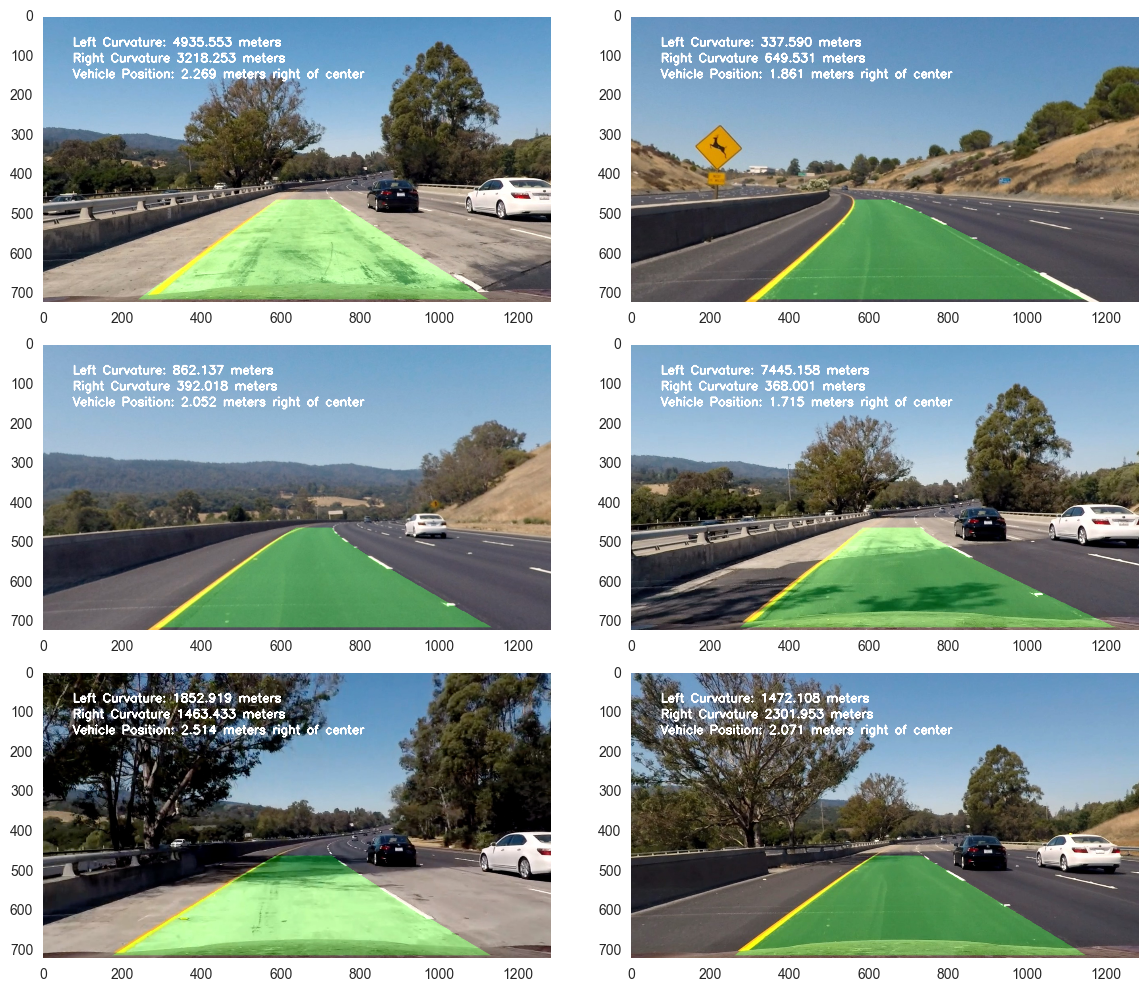

In [11]:
fig, ax = plt.subplots(3,2,figsize=(12,10))
row, col = np.unravel_index(np.arange(6), (3,2))
plt_counter = 0

for img_path in sorted(glob.glob('test_images/*.jpg')):
    # Read image.
    img_rgb = mpimg.imread(img_path)   

    # Process image
    processed_image = process_image(img_rgb, single_frame=True)
    
    ax[row[plt_counter],col[plt_counter]].imshow(processed_image)
    ax[row[plt_counter],col[plt_counter]].grid(False)
    plt_counter += 1
    
plt.tight_layout()
plt.show()

# Application of Pipeline to Video Sequence

In [14]:
processed_output = 'project_video_processed.mp4'
clip1 = VideoFileClip("project_video.mp4")
processed_clip = clip1.fl_image(process_image)
%time processed_clip.write_videofile(processed_output, audio=False)

[MoviePy] >>>> Building video project_video_processed.mp4
[MoviePy] Writing video project_video_processed.mp4


100%|█████████▉| 1260/1261 [03:03<00:00,  7.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_processed.mp4 

CPU times: user 11min 57s, sys: 40.9 s, total: 12min 38s
Wall time: 3min 3s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(processed_output))